<a href="https://colab.research.google.com/github/AnSay0/Projects/blob/AI/ForecastingGBP_USD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
data = pd.read_csv(r'/content/DAT_MT_GBPUSD_M1_2021.csv', names=["time", "open", "high", "low", "close", "volume"])
data.reset_index(inplace=True)
data.drop('volume', axis=1, inplace=True)
data.rename(columns={'index':'date'}, inplace=True)
data['date'] = data['date'].apply(lambda x: x[5:])
data.head(-1)

,date,time,open,high,low,close
0,01.03,17:00,1.36455,1.36502,1.36455,1.36470
1,01.03,17:01,1.36479,1.36500,1.36471,1.36495
2,01.03,17:02,1.36494,1.36512,1.36494,1.36505
3,01.03,17:03,1.36511,1.36511,1.36505,1.36508
4,01.03,17:04,1.36505,1.36515,1.36488,1.36492
...,...,...,...,...,...,...
370392,12.31,16:53,1.35265,1.35286,1.35265,1.35280
370393,12.31,16:54,1.35280,1.35280,1.35227,1.35239
370394,12.31,16:55,1.35241,1.35259,1.35239,1.35239
370395,12.31,16:56,1.35240,1.35245,1.35203,1.35218


In [ ]:
data['idx'] = (np.array([str(i%5) for i in range(data.shape[0])]))
data['idx'] = data['idx'].astype('int64')
data = data.loc[data['idx'] == 4]
data.drop("idx", axis=1, inplace=True)
data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,time,open,high,low,close
4,01.03,17:04,1.36505,1.36515,1.36488,1.36492
9,01.03,17:09,1.36486,1.36490,1.36480,1.36487
14,01.03,17:14,1.36489,1.36490,1.36489,1.36490
19,01.03,17:19,1.36489,1.36493,1.36488,1.36489
24,01.03,17:24,1.36550,1.36551,1.36537,1.36537


In [ ]:
data["date"] = data["date"].astype('category')
data["time"] = data["time"].astype('category')
data["date"] = data["date"].cat.codes
data["time"] = data["time"].cat.codes

In [ ]:
sz = 25000
input = 1000
output = 1000
data = data[-sz:]
data.shape

(25000, 6)

In [ ]:
from sklearn import preprocessing
scaler2 = preprocessing.MinMaxScaler()
scaler2.fit(data["close"].values.reshape(-1, 1))
scaler = preprocessing.MinMaxScaler()
data = scaler.fit_transform(data)


In [ ]:
# convert history into inputs and outputs
def to_supervised(data, n_input, n_out):
	# flatten data
	#data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(data.shape[0]):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= data.shape[0]:
			x_input = data[in_start:in_end]
			x_input = x_input.reshape((x_input.shape))
			X.append(x_input)
			y.append(data[in_end:out_end, 5])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

x, y = to_supervised(data,input, output)

In [ ]:
x_train = x[:-100]
y_train = y[:-100]
x_test = x[-100:]
y_test = y[-100:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape


((22901, 1000, 6), (22901, 1000), (100, 1000, 6), (100, 1000))

In [ ]:
np.isnan(x_train).sum(), np.isnan(y_train).sum(), np.isnan(x_test).sum(), np.isnan(y_test).sum()

(0, 0, 0, 0)

In [ ]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization as bn
from tensorflow.keras.metrics import Metric
# train the model
lr = ks.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

def build_model(train_x, train_y):

  # define parameters
  verbose, epochs, batch_size = 1, 1, 128
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # define model
  model = ks.Sequential()
  model.add(ks.layers.LSTM(200, activation='selu', input_shape=(n_timesteps, n_features)))
  model.add(bn())
  model.add(ks.layers.Dense(100, activation='selu'))
  model.add(bn())
  model.add(ks.layers.Dense(n_outputs))
  model.compile(loss='mse', optimizer=optimizers.Adam(amsgrad=True,clipvalue=2.0))
  # fit network
  model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
  return model

model = build_model(x_train, y_train)

179/179 [==============================] - 299s 2s/step - loss: 0.1075


In [ ]:
pre = model.predict(x_test)

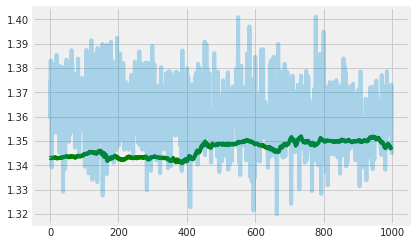

In [ ]:
# the blue lline is the prediction

plt.plot((scaler2.inverse_transform(y_test)[0]), color="green");
plt.plot((scaler2.inverse_transform(pre)[0]), alpha=0.3);

In [ ]:
pre.shape[0]

100

In [ ]:
# error for all predction 100
mse = tf.keras.losses.MeanSquaredError()
mse(y_test, pre).numpy(), mse(y_test[0], pre[0]).numpy()

(0.06707445, 0.069437884)

In [ ]:
pree = pre.copy()
for j in range(pre.shape[0]):
  for i in range(1,pre[j].shape[0]):
      pree[j][i] = np.mean(pre[j][max(0,i-30):i])


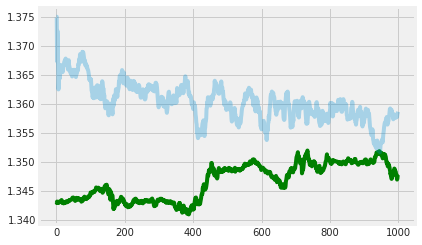

In [ ]:
# the blue lline is the prediction

plt.plot((scaler2.inverse_transform(y_test)[0]), color="green");
plt.plot((scaler2.inverse_transform(pree)[0]), alpha=0.3);

In [ ]:
# error for all predction 100
mse = tf.keras.losses.MeanSquaredError()
mse(y_test, pree).numpy(), mse(y_test[0], pree[0]).numpy()

(0.03926184, 0.04146009)

In [ ]:
pree = pre.copy()
for j in range(pre.shape[0]):
  for i in range(1,pre[j].shape[0]):
    if i <= 300:
      pree[j][i] = np.min(pre[j][max(i-10,0):i])
    elif i<= 600:
      pree[j][i] = np.mean(pre[j][i-10:i])
    else :
      pree[j][i] = np.max(pre[j][i-10:i])

In [ ]:
scaler2.inverse_transform(pre)[0]

array([1.3749641, 1.3596032, 1.3830947, 1.3669779, 1.3509393, 1.3390394,
       1.370027 , 1.3806014, 1.3532945, 1.3650773, 1.3739012, 1.3815725,
       1.3597202, 1.3730084, 1.3543863, 1.3667089, 1.3712466, 1.353416 ,
       1.367712 , 1.3854004, 1.3706571, 1.3676554, 1.375808 , 1.3714921,
       1.3709679, 1.3612995, 1.3809716, 1.363755 , 1.3451543, 1.3808078,
       1.3525965, 1.3683941, 1.364727 , 1.3555939, 1.3733419, 1.3650459,
       1.3430152, 1.375946 , 1.3290803, 1.3665048, 1.3804108, 1.3591449,
       1.3686838, 1.3785809, 1.3384444, 1.3543749, 1.3779926, 1.3652959,
       1.3834401, 1.3756945, 1.3725281, 1.3616644, 1.3796144, 1.3816717,
       1.3639966, 1.3496084, 1.3621372, 1.375289 , 1.3522204, 1.3822277,
       1.3704973, 1.3700093, 1.3596405, 1.3873231, 1.3698502, 1.3813387,
       1.3575882, 1.3630403, 1.3654324, 1.3689888, 1.3534863, 1.3735129,
       1.372185 , 1.3472397, 1.366541 , 1.3775736, 1.3738931, 1.3678099,
       1.3776884, 1.362795 , 1.3563137, 1.3495414, 

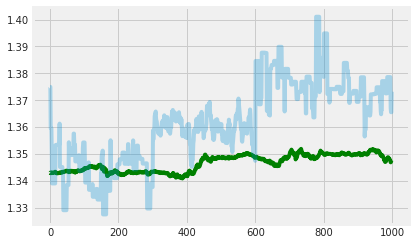

In [ ]:
# the blue lline is the prediction

plt.plot((scaler2.inverse_transform(y_test)[0]), color="green");
plt.plot((scaler2.inverse_transform(pree)[0]), alpha=0.3);

In [ ]:
# error for all predction 100
mse = tf.keras.losses.MeanSquaredError()
mse(y_test, pree).numpy(), mse(y_test[0], pree[0]).numpy()

(0.074122995, 0.07910838)

In [ ]:
# error for prediction of one exmaple
mse(y_test[0], pree[0]).numpy()

0.07910838

In [ ]:
model.save('model_gbpusd.save',save_format='h5')